In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

plt.rcParams['figure.dpi'] = 300
%config InlineBackend.figure_format = 'retina'
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

In [2]:
def basemap_base(name_projection,axes,lat,lon,lon0,fill_type):
    m = Basemap(projection=name_projection,lon_0=0,boundinglat=lon0,resolution='l',ax=axes,round=True)

    lon2, lat2 = np.meshgrid(lon,lat)
    x, y = m(lon2,lat2)

    
    if(fill_type == 'FILL'): m.fillcontinents(color='grey',lake_color='gray')
        
    m.drawcoastlines(linewidth=0.5)
    m.drawmapboundary(fill_color='white')
    
    return m, x, y;

In [3]:
def mon_to_ann_DJF(ds):
    
    ds_DJF_all = ds.where(ds['time.season'] == 'DJF')
    
    # Rolling mean -> only Jan is not nan
    # However, we loose Jan/ Feb in the first year and Dec in the last
    ds_DJF = ds_DJF_all.rolling(min_periods=3, center=True, time=3).mean()
    
    # Exceptional Case for first year
    ds_DJF[0] = ds_DJF_all[0:2].mean()

    # make annual mean
    ds_DJF = ds_DJF.groupby('time.year').mean('time')
    
    return ds_DJF

## 1. Read the Geopotential Height data (NCEP Reanalysis)

In [4]:
dir_name  = "./DATA/"
file_name = "hgt_anom.mon.mean.nc"
path_name = dir_name+file_name

f         = xr.open_dataset(path_name)
hgt       = f.hgt  ## Geopotential Height [m]
time      = f.time
lat_ATM   = f.lat  ## Latitude  [^o]
lon_ATM   = f.lon  ## Longitude [^o]

### 1-1) Slice the latitude / logitude / time

In [5]:
latS = 30.     ; latN = 90.
lonL = 0.     ; lonR = 360.

year_str = 1982 ; year_end = 2020

In [6]:
season = ["DJF"]

## Find the time index for speicified year
ind_year = np.where((time.dt.year>=year_str) & 
                    (time.dt.year<=year_end) )[0]

## Slice the Geopotential Height array for specified time, latitude and longitude
Z_pos         = 1000 # [hPa]
hgt_slice     = hgt.sel(lat=slice(latN,latS),lon=slice(lonL,lonR),level=Z_pos)[ind_year,:,:]

## Convert monthly data to "DJF" mean annual data
hgt_slice_DJF = mon_to_ann_DJF(hgt_slice)
Nt_DJF, Ny_ATM, Nx_ATM = hgt_slice_DJF.shape

### 1-2) Make the Geopotential array to 2D matrix

In [7]:
## Convert the array to 2D matrix
hgt_2D_DJF   = hgt_slice_DJF.values.reshape(Nt_DJF,-1)

## 2. Conduct the SVD Decomposition
### (Singular Value Decomposition)

In [8]:
N_comp = 5 ## The number of PC (Principal Component)

## Conduct the Singular Value Decomposition (SVD)
tmp_SVD_var = hgt_2D_DJF

svd_tr = TruncatedSVD(n_components=N_comp)
svd_tr.fit(tmp_SVD_var)

TS_pc  =  svd_tr.fit_transform(tmp_SVD_var)  ## Time-Series of PCs 
VAR_pc =  svd_tr.explained_variance_ratio_   ## Variances for PCs
SP_pc  =  svd_tr.components_                 ## Spatial patterns for PCs

## 3. Plot SVD Statistics

### 3-1) Plot the Variance Ratio fo each PC

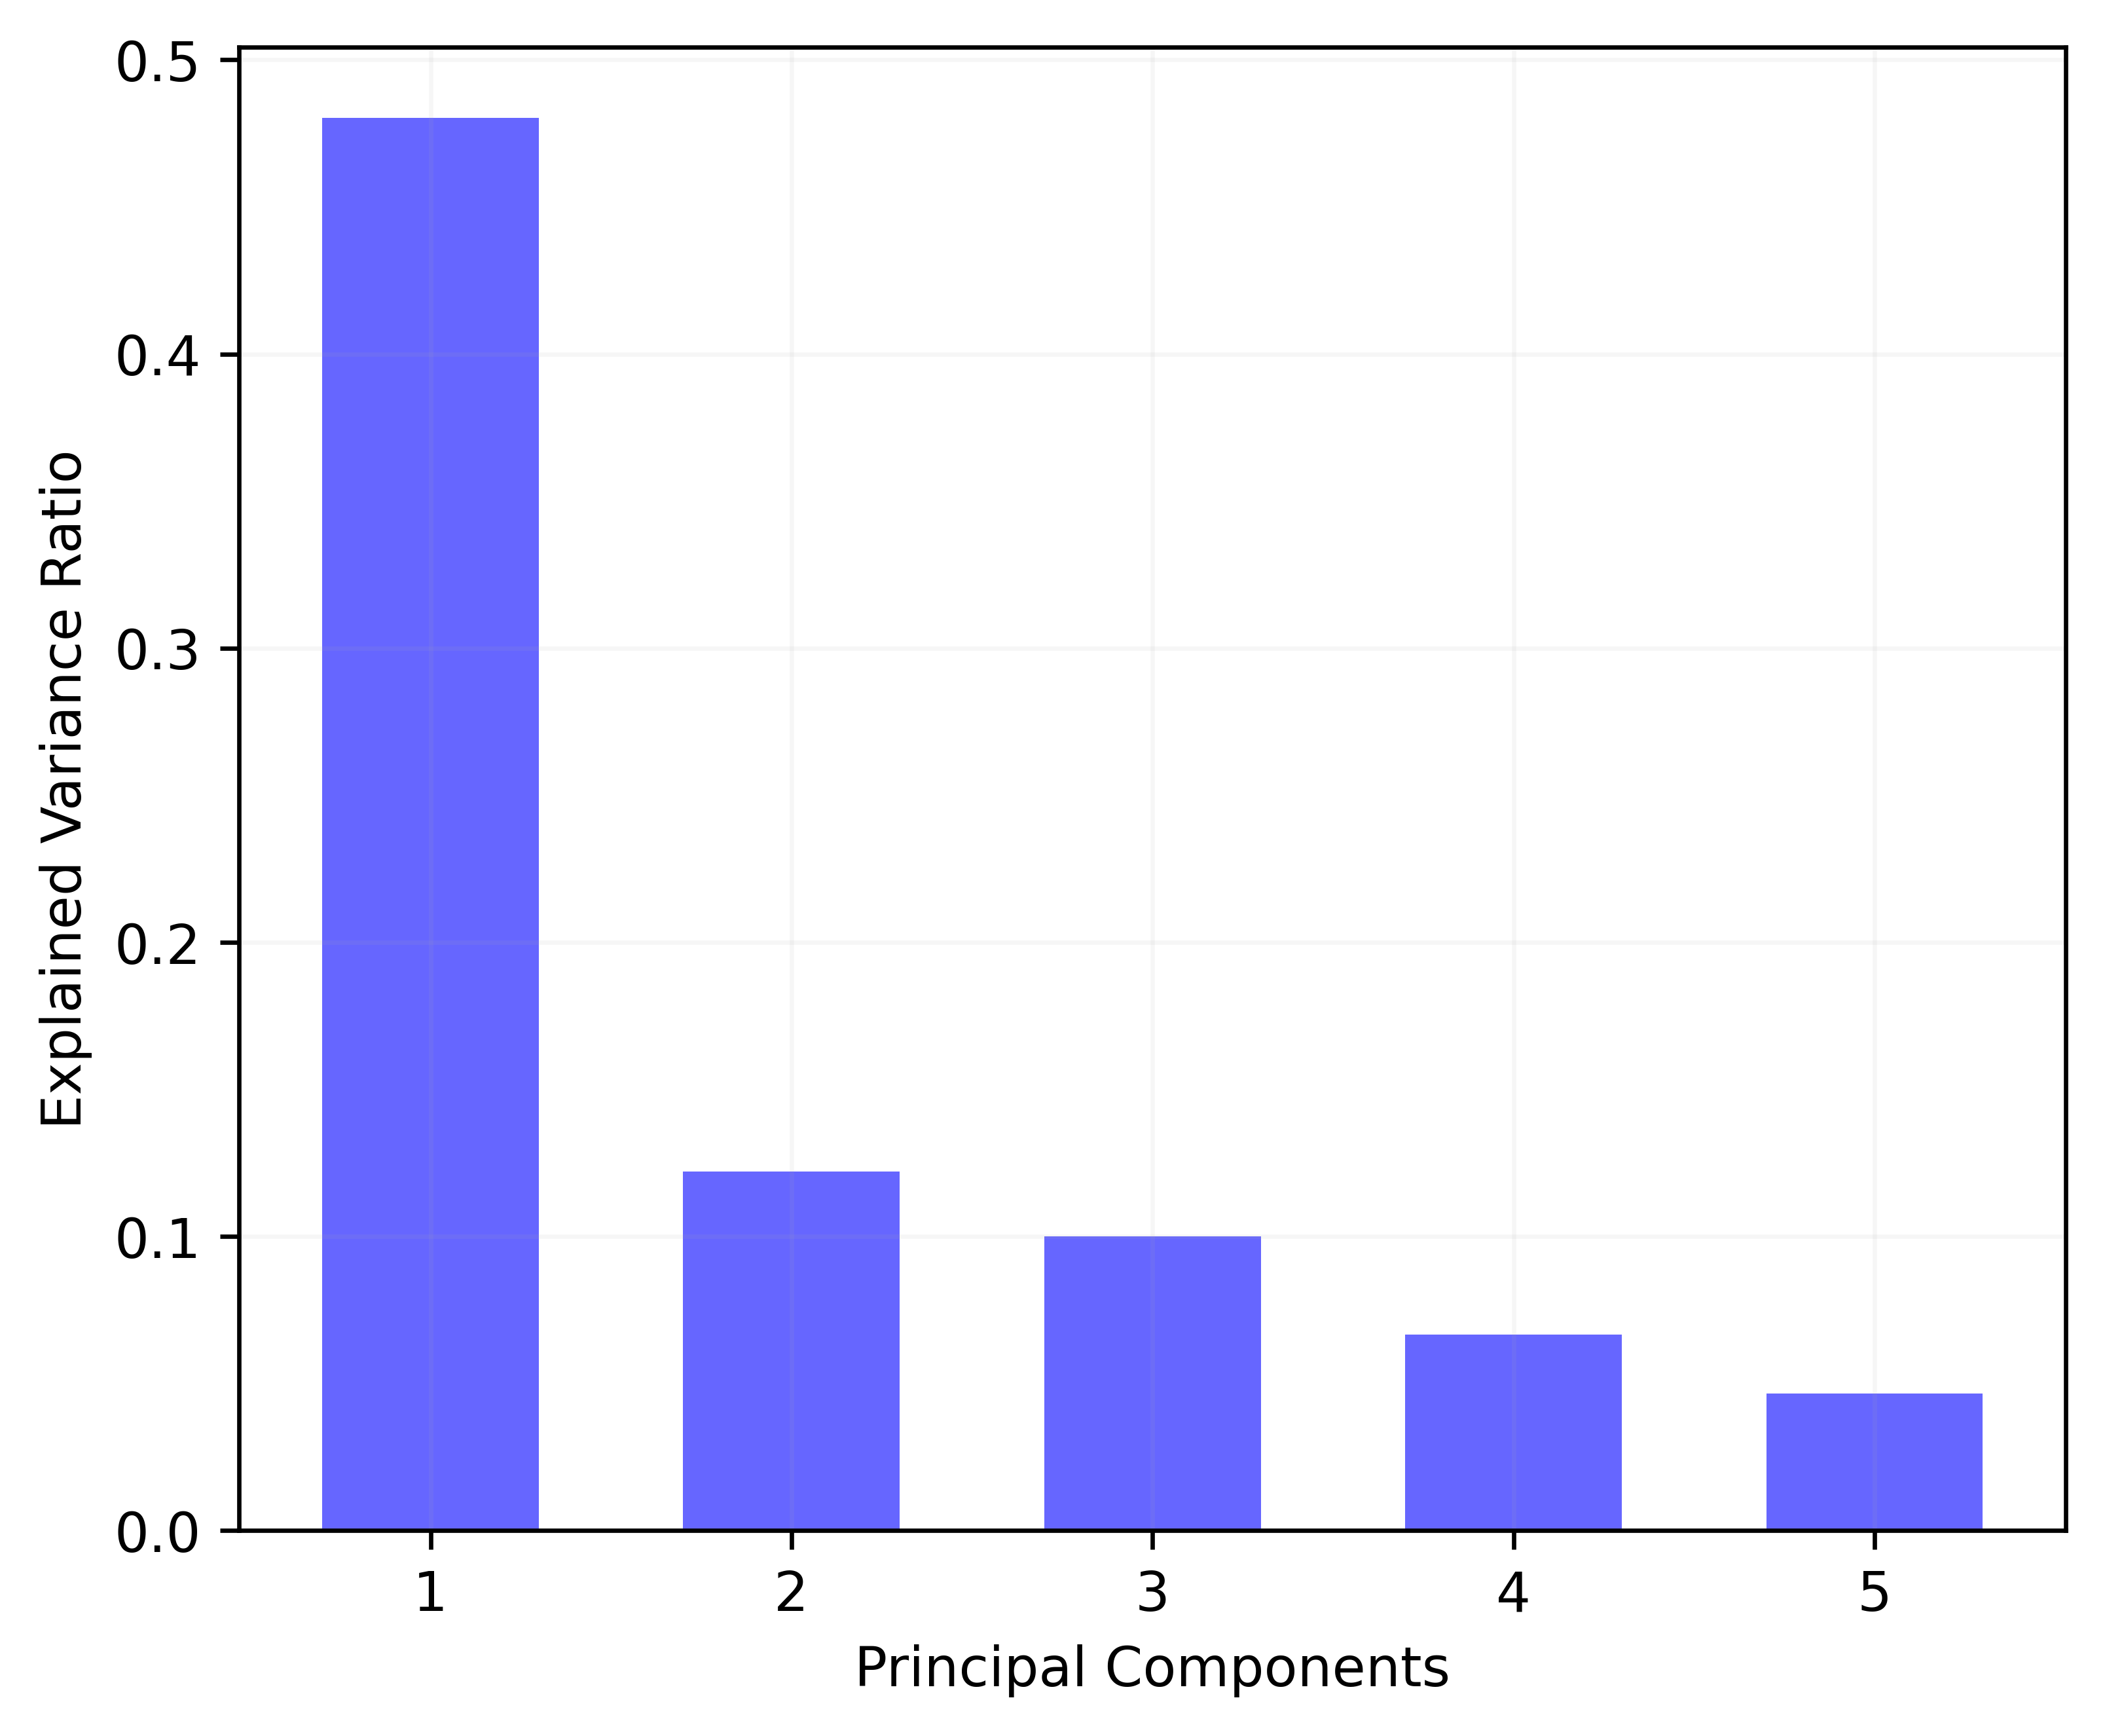

In [9]:
figs,axes = plt.subplots(1,1,figsize=(6,5))
axes.bar(np.linspace(1,N_comp,N_comp),VAR_pc,
                     color='b',width=0.6,alpha=0.6)
axes.set_xlabel("Principal Components")
axes.set_ylabel("Explained Variance Ratio")
axes.grid(alpha=0.1)

### 3-2) Plot the PC Time Series

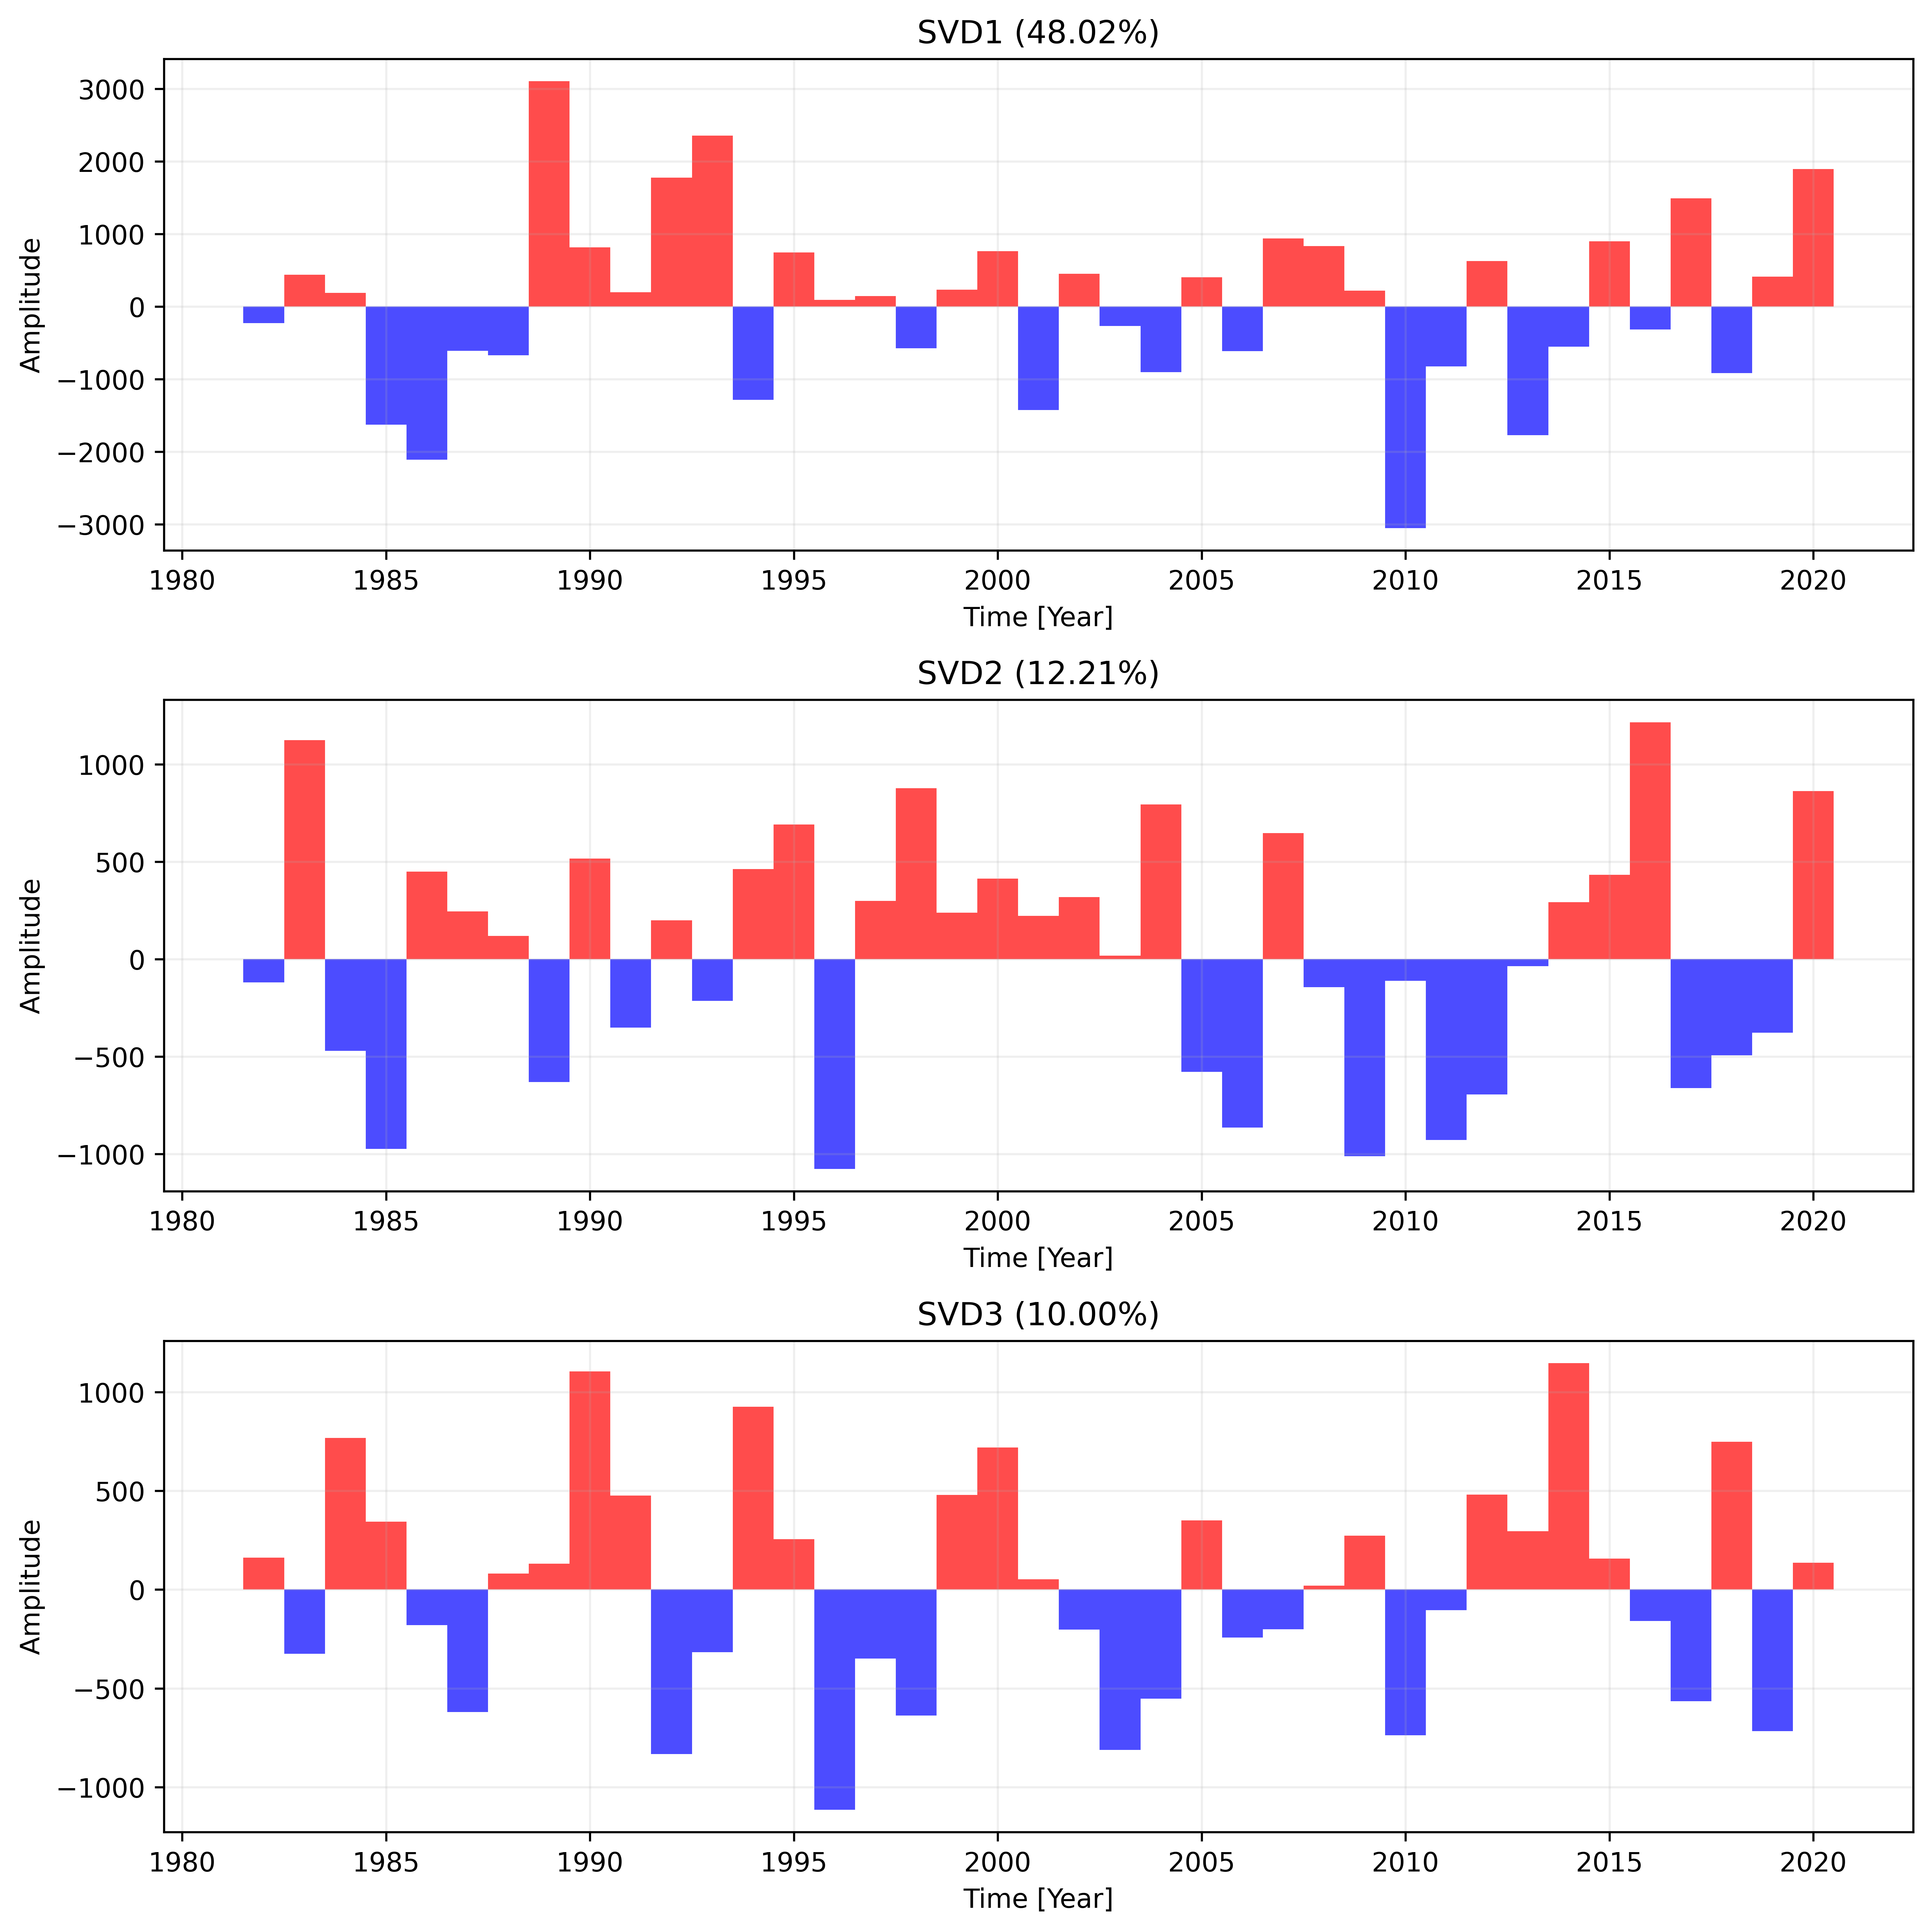

In [10]:
fig, axes = plt.subplots(3,1,figsize=(10,10),constrained_layout=True)

for ind_PC in range(3):
    ind_pos = np.where(TS_pc[:,ind_PC]>=0)[0]
    ind_neg = np.where(TS_pc[:,ind_PC]<0)[0]

    tmp_time = time[ind_year].groupby("time.year").mean().dt.year
    width_bar = 1
        
    axes[ind_PC].bar(tmp_time[ind_pos],TS_pc[ind_pos,ind_PC],
                     width=width_bar,color='r',alpha=0.7)
    axes[ind_PC].bar(tmp_time[ind_neg],TS_pc[ind_neg,ind_PC],
                     width=width_bar,color='b',alpha=0.7) 
    
    axes[ind_PC].set_xlabel("Time [Year]")
    axes[ind_PC].set_ylabel("Amplitude")
    axes[ind_PC].set_title("SVD"+str(ind_PC+1)+
                           " ({:4.2f}%)".format(VAR_pc[ind_PC]*100))
    axes[ind_PC].grid(alpha=0.2)
    

### 3-3) Plot the PC Spatial Pattern for each PC

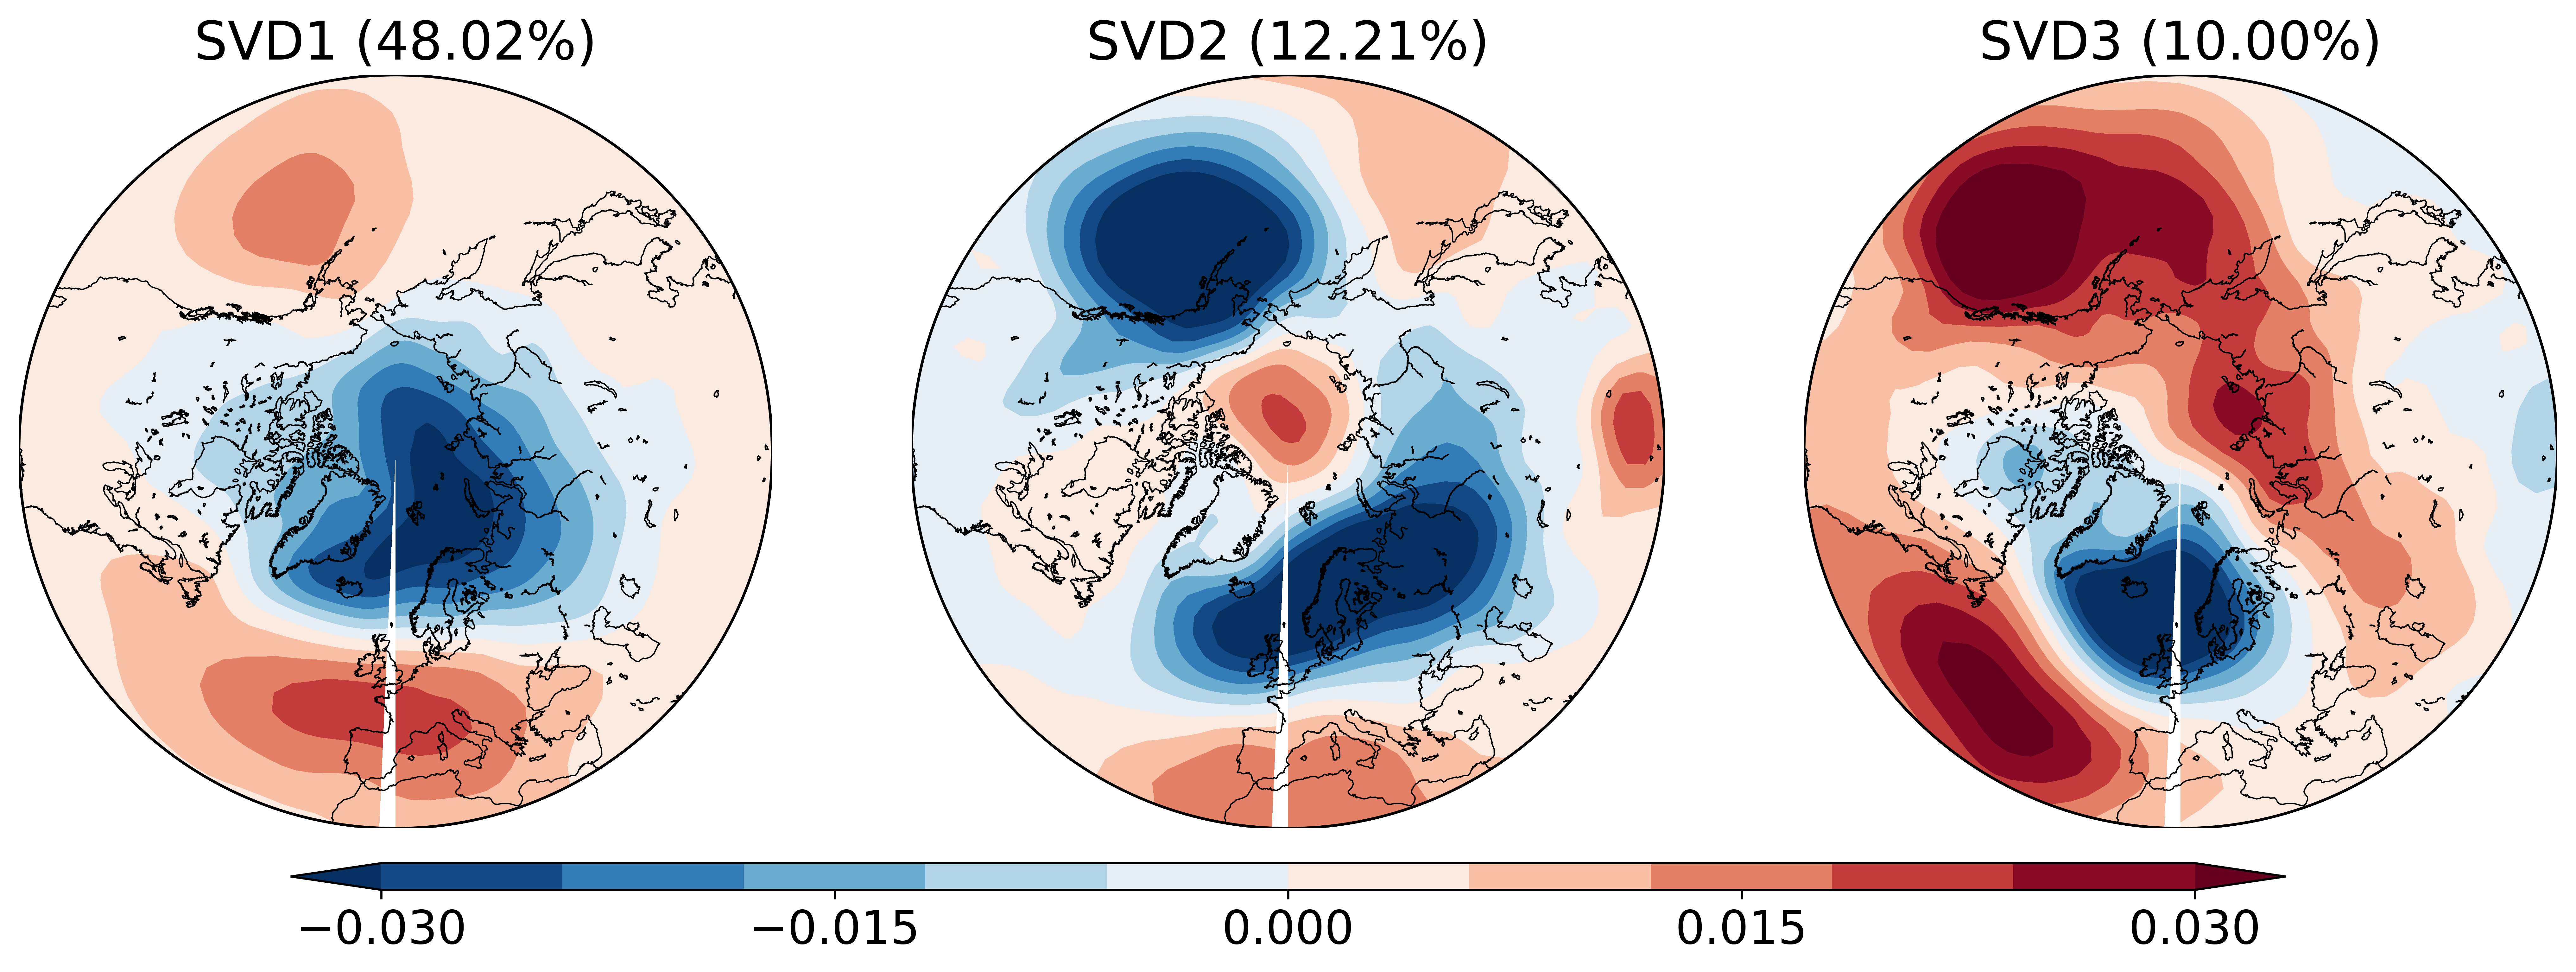

In [11]:
fig, axes = plt.subplots(1,3,figsize=(14,5),constrained_layout=True)

for ind_PC in range(3):
    var_recon_1D    = np.empty([Ny_ATM*Nx_ATM])
    var_recon_1D[:] = np.NaN

    var_recon_1D[:] = SP_pc[ind_PC,:]
    tmp_var = var_recon_1D.reshape(Ny_ATM,Nx_ATM)
    
    m, x, y = basemap_base('npstere',axes[ind_PC],lat_ATM.sel(lat=slice(latN,latS)),
                                                  lon_ATM.sel(lon=slice(lonL,lonR)),
                                                  latS,'NOFILL')

    vmin      = -3e-2 ; vmax  = 3e-2
    levels    = 10    ; level_boundaries = np.linspace(vmin,vmax,levels+1)

    contour_var = m.contourf(x,y,tmp_var,level_boundaries,cmap='RdBu_r',extend='both')
    axes[ind_PC].set_title("SVD"+str(ind_PC+1)+
                           " ({:4.2f}%)".format(VAR_pc[ind_PC]*100),fontsize=20)
    
cb = fig.colorbar(contour_var,ax=axes, shrink=0.75,location='bottom')
cb.set_ticks([-3e-2,-1.5e-2,0,1.5e-2,3e-2])
cb.ax.tick_params(labelsize=17.5)